In [1]:
import osmnx as ox
import pandana
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.1'

In [2]:
# Select city (COP, HEL, WAR)
city = 'HEL'

if city == 'COP':
    cityname = 'Copenhagen, Denmark'
    minx, miny, maxx, maxy = 12.42000, 55.61000, 12.65000, 55.78000
elif city == 'HEL':
    cityname = 'Helsinki, Finland'
    minx, miny, maxx, maxy = 24.82345, 60.14084, 25.06404, 60.29496
elif city == 'WAR':
    cityname = 'Warsaw, Poland'
    minx, miny, maxx, maxy = 20.79057, 52.09901, 21.31300, 52.38502

In [3]:
# Get graph by geocoding
try:
    graph = ox.graph_from_place(cityname, network_type="walk")
    ignore_geocoding = False

# Get graph based on bbox if geocoding fails (copenhagen has no polygon on nominatim)
except ValueError:
    graph = ox.graph_from_bbox(maxy, miny, maxx, minx, network_type="walk")
    ignore_geocoding = True

# Project graph for accurate simplification (and more accurate poi centroids later on)
graph = ox.projection.project_graph(graph, to_crs=3035)

In [4]:
# Simplify graph (try to get real intersections only)
graph = ox.simplification.consolidate_intersections(
    # Graph to simplify
    graph,
    # consolidate nodes within 10m from eachother
    tolerance=10,
    # Get result as graph (False to get nodes only as gdf)
    rebuild_graph=True,
    # Include dead ends
    dead_ends=True,
    # Reconnect the graph
    reconnect_edges=True
)

In [5]:
# Max time to walk in minutes (no routing to nodes further than this)
walk_time = 15

# Walking speed
walk_speed = 4.5

# Set a uniform walking speed on every edge
for u, v, data in graph.edges(data=True):
    data['speed_kph'] = walk_speed

graph = ox.add_edge_travel_times(graph)

# Extract node/edge GeoDataFrames, retaining only necessary columns (for pandana)
nodes = ox.graph_to_gdfs(graph, edges=False)[['x', 'y']]
edges = ox.graph_to_gdfs(graph, nodes=False).reset_index()[['u', 'v', 'travel_time']]

In [6]:
# Select pois based on osm tags
tags = {
    'amenity':[
        'cafe',
        'bar',
        'pub',
        'restaurant'
    ],
    'shop':[
        'bakery',
        'convenience',
        'supermarket',
        'mall',
        'department_store',
        'clothes',
        'fashion',
        'shoes'
    ],
    'leisure':[
        'fitness_centre'
    ]
}

# Get amentities from place/bbox
if ignore_geocoding == True:
    amenities = ox.geometries.geometries_from_bbox(
        maxy, miny, maxx, minx,
        tags=tags
    )
else:
    amenities = ox.geometries.geometries_from_place(
        cityname,
        tags=tags
    )
# Project amenities
amenities = amenities.to_crs(epsg=3035)

In [7]:
# Save as gpkg
#amenities_point = amenities[amenities['geometry'].apply(lambda x: x.type=='Point')]
#amenities_point.to_file('amenities_'+city+'.gpkg', driver='GPKG')

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Construct the pandana network model
network = pandana.Network(
    node_x=nodes['x'],
    node_y=nodes['y'], 
    edge_from=edges['u'],
    edge_to=edges['v'],
    edge_weights=edges[['travel_time']]
)

# Extract centroids from the amenities' geometries
centroids = amenities.centroid

In [9]:
# Specify a max travel distance for analysis
# Minutes -> seconds
maxdist = walk_time * 60

# Set the amenities' locations on the network
network.set_pois(
    category='pois',
    maxdist=maxdist,
    maxitems=10,
    x_col=centroids.x, 
    y_col=centroids.y
)

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:660: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxitems, type(pd.Series())):
/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/pandana/network.py:668: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  elif isinstance(maxdist, type(pd.Series())):


In [10]:
# calculate travel time to 10 nearest amenities from each node in network
distances = network.nearest_pois(
    distance=maxdist,
    category='pois',
    num_pois=10
)

distances.astype(int).head()

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
0,67,200,200,200,200,900,900,900,900,900
1,0,133,133,133,133,900,900,900,900,900
2,413,546,546,546,546,900,900,900,900,900
3,79,212,212,212,212,900,900,900,900,900
4,466,599,599,599,599,900,900,900,900,900


/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


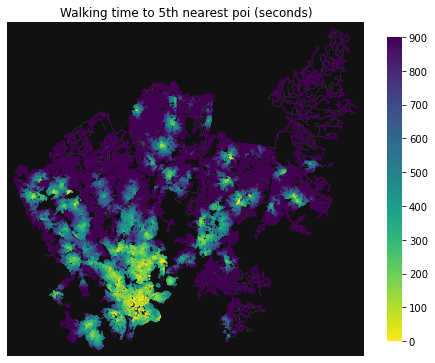

In [11]:
# plot distance to nearest amenity
fig, ax = ox.plot_graph(
    graph,
    node_size=0,
    edge_linewidth=0.1,
    edge_color='gray',
    show=False,
    close=False
)

sc = ax.scatter(
    x=nodes['x'],
    y=nodes['y'], 
    c=distances[5],
    s=1,
    cmap='viridis_r'
)

ax.set_title(f'Walking time to 5th nearest poi (seconds)')
plt.colorbar(sc, shrink=0.7).outline.set_edgecolor('none')

In [12]:
# check data
distances.head()

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,
0,67.199997,200.300003,200.300003,200.300003,200.300003,900.0,900.0,900.0,900.0,900.0
1,0.000000,133.100006,133.100006,133.100006,133.100006,900.0,900.0,900.0,900.0,900.0
2,413.500000,546.599976,546.599976,546.599976,546.599976,900.0,900.0,900.0,900.0,900.0
3,79.500000,212.600006,212.600006,212.600006,212.600006,900.0,900.0,900.0,900.0,900.0
4,466.200012,599.299988,599.299988,599.299988,599.299988,900.0,900.0,900.0,900.0,900.0


In [13]:
nodes.head()

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,x,y
osmid,,
0,5.140167e+06,4.206374e+06
1,5.140239e+06,4.206409e+06
2,5.140534e+06,4.206788e+06
3,5.140324e+06,4.206452e+06
4,5.140581e+06,4.206798e+06


In [14]:
# Get simplified nodes with wgs coords for output csv
graph_wgs = ox.projection.project_graph(graph, to_crs=4326)
nodes_wgs = ox.graph_to_gdfs(graph_wgs, edges=False)[['x', 'y']]

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Join travel time info to nodes
walk_access = nodes.join(distances, on='osmid', how='left')
walk_access_wgs = nodes_wgs.join(distances, on='osmid', how='left')

In [16]:
walk_access_wgs.head()

,x,y,1,2,3,4,5,6,7,8,9,10
osmid,,,,,,,,,,,,
0,24.849017,60.181524,67.199997,200.300003,200.300003,200.300003,200.300003,900.0,900.0,900.0,900.0,900.0
1,24.850418,60.181699,0.000000,133.100006,133.100006,133.100006,133.100006,900.0,900.0,900.0,900.0,900.0
197,24.850549,60.180954,65.800003,65.800003,65.800003,65.800003,67.300003,900.0,900.0,900.0,900.0,900.0
198,24.851726,60.181862,62.900002,196.000000,196.000000,196.000000,196.000000,900.0,900.0,900.0,900.0,900.0
11430,24.849494,60.182298,79.500000,212.600006,212.600006,212.600006,212.600006,900.0,900.0,900.0,900.0,900.0


In [17]:
# Save as CSV
walk_access_wgs.to_csv('walk_access_'+city+'.csv', encoding='utf-8')

/home/gispo_user/miniconda3/envs/gis/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
